1- Tiền xử lý dữ liệu: Làm sạch dữ liệu, loại bỏ dư thừa, tách từ, stopword

2- Chia bộ dữ liệu thành Train/Test với tỉ lệ 0.7

3- Sử dụng WordEmbedding của thư viện Keras hỗ trợ cho dữ liệu đã xử lý ở trên, lưu kết quả wordembedding đó ra 1 file KerasWordEmbedding.txt

4- Sử dụng pretrained word embedding Fasttext (Facebook AI Research), lấy wordembedding của bộ dữ liệu trên ra 1 file FastTextWordEmbedding.txt

5- Sử dụng PhoBert cho bộ dữ liệu trên, lưu kết quả ra file PhoBertEmbedding.txt

6- Sử dụng 1 trong 3 kết quả ở các câu 2,3,4 là đầu vào cho các mô hình học sâu: MLP, RNN, LSTM, BiLSTM và CNN (các tham số của mô hình tự xây dựng) cho bài toán phân lớp ý kiến người dùng. In ra các tham số của mô hình huấn luyện

7- Đánh giá với 3 độ đo Accuracy, Confusion Matrix và F1-score và lưu kết quả ra 1 file

8- Với mô hình học sâu có kết quả cao nhất ở trên, sử dụng điểm Checkpoint để lưu kết quả huấn luyện với epoch cho kết quả cao nhất

9- Người dùng nhập vào một câu, sử dụng mô hình đã lưu ở trên dự đoán ý kiến của người dùng và in ra kết quả

In [149]:
# BATCH_SIZE = 100
SEED = 61

import re
import time
import string
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# tf.keras.utils.set_random_seed(SEED)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding,SimpleRNN, LSTM, Input, Flatten, Convolution1D, MaxPool1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from gensim.models.fasttext import FastText
from gensim.models import Word2Vec

import fasttext
import fasttext.util

import matplotlib.pyplot as plt

# import torch
# from transformers import AutoModel, AutoTokenizer

In [6]:
# colab_path = '/content/drive/MyDrive/DACNTT2/tasks/Text Sentiment Analysis/'

train_path = '../input/cleaned-sentiment-text/train.csv'
validation_path = '../input/cleaned-sentiment-text/validation.csv'
test_path = '../input/cleaned-sentiment-text/test.csv'

In [7]:
# data is already cleaned and splitted in 3 parts: train, validation and test
train_df = pd.read_csv(train_path, index_col=0)
validation_df = pd.read_csv(validation_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)
NUM_CLASSES = len(train_df['label'].unique())
index2class = {0:'neg', 1:'pos'}
class2index = {'neg': 0, 'pos':1}

print('Number of train data:', train_df.shape[0])
print('Number of validation data:', validation_df.shape[0])
print('Number of test data:', test_df.shape[0])
print('Number of classes:', NUM_CLASSES, '->', train_df['label'].unique())

train_df.head()

Number of train data: 29744
Number of validation data: 9920
Number of test data: 9920
Number of classes: 2 -> ['neg' 'pos']


,text,label
0,hôm_nay đi ngang quán quyết_định ghé mua quán ...,neg
1,đến_súp lơ trưa nắng gắt chủ_nhật hy_vọng súp ...,pos
2,hôm_qua xe đông khiếp lo bàn may_sao bàn lầu l...,pos
3,món ăn_ở ngon món bò kho chủ quán quán phục_vụ...,pos
4,đẹp trời đi mỳ mỳ vô_cùng mặn sợi bở bàn phục_...,neg


In [8]:
# X
train_data = train_df.iloc[:, 0].to_numpy()
validation_data = validation_df.iloc[:, 0].to_numpy()
test_data = test_df.iloc[:, 0].to_numpy()
whole_data = np.concatenate((train_data, validation_data, test_data), dtype=object)

In [9]:
# y
label_train = np.array([class2index[i] for i in train_df.iloc[:, 1]])
label_validation = np.array([class2index[i] for i in validation_df.iloc[:, 1]])
label_test = np.array([class2index[i] for i in test_df.iloc[:, 1]])
label_whole = np.concatenate((label_train, label_validation, label_test))

In [10]:
MAXLEN = max([len(x.split()) for x in whole_data]) # = 492
EMBEDDING_DIM = 100

# 6 - Sử dụng 1 trong 3 kết quả ở các câu 2,3,4 là đầu vào cho các mô hình học sâu: MLP, RNN, LSTM, BiLSTM và CNN (các tham số của mô hình tự xây dựng) cho bài toán phân lớp ý kiến người dùng. In ra các tham số của mô hình huấn luyện

In [ ]:
# load fasttext trained embedding layer weights to get feature vector accordingly
ft_loaded = fasttext.load_model('data/embedding/fasttext/FastTextEmbeddingModel.bin')

In [ ]:
def fasttext_pretrained_embed_sentence(sent):
    embedded_sent = np.zeros((EMBEDDING_DIM, ))
    for i, word in enumerate(sent.split()):
        embedded_sent += ft_loaded.get_word_vector(word)
    return (embedded_sent/len(sent.split())).ravel().tolist()

fasttext_pretrained_embed = np.frompyfunc(fasttext_pretrained_embed_sentence, 1, 1)

In [ ]:
X_train = np.array(fasttext_pretrained_embed(train_data).tolist())

In [ ]:
X_validation = np.array(fasttext_pretrained_embed(validation_data).tolist())

In [ ]:
X_test = np.array(fasttext_pretrained_embed(test_data).tolist())

In [ ]:
# def fasttext_pretrained_embed_sentence(sent):
#     embedded_data = np.zeros((MAXLEN, EMBEDDING_DIM))
#     for i, word in enumerate(sent.split()):
#         embedded_data[i] = ft_loaded.get_word_vector(word)
#     return embedded_data

# fasttext_pretrained_embed = np.frompyfunc(fasttext_pretrained_embed_sentence, 1, 1)

# fasttext_pretrained_embedding_train = fasttext_pretrained_embed(train_data)
# fasttext_pretrained_embedding_validation = fasttext_pretrained_embed(validation_data)
# fasttext_pretrained_embedding_test = fasttext_pretrained_embed(test_data)

# X_train = np.array([np.mean([i for i in x], axis=0) for x in fasttext_pretrained_embedding_train])
# X_validation = np.array([np.mean([i for i in x], axis=0) for x in fasttext_pretrained_embedding_validation])
# X_test = np.array([np.mean([i for i in x], axis=0) for x in fasttext_pretrained_embedding_test])

In [ ]:
np.save('data/embedding/fasttext/X_train.npy', X_train)
np.save('data/embedding/fasttext/X_validation.npy', X_validation)
np.save('data/embedding/fasttext/X_test.npy', X_test)

In [2]:
# load saved embedded data
# data/embedding/fasttext/X_train.npy
X_train = np.load('../input/embeddings/X_train.npy', allow_pickle=True)
X_validation = np.load('../input/embeddings/X_validation.npy', allow_pickle=True)
X_test = np.load('../input/embeddings/X_test.npy', allow_pickle=True)

# MLP

In [80]:
early_stopping = EarlyStopping(patience=5, monitor="val_loss", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, verbose=1)
# mlp.optimizer.get_config()
# adam initial learning rate = 0.001

In [13]:
mlp = Sequential()
mlp.add(Input(shape=(EMBEDDING_DIM,)))
mlp.add(Dense(200, activation='relu'))
mlp.add(Dense(100, activation='relu'))
mlp.add(Dense(20, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 42,341
Trainable params: 42,341
Non-trainable params: 0
_________________________________________________________________
None


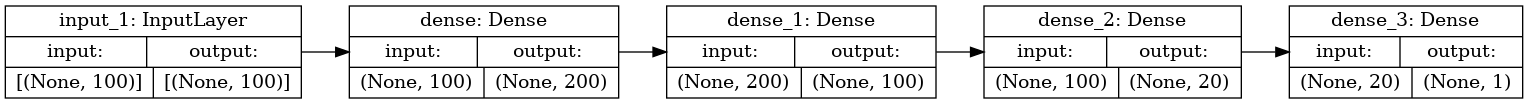

In [143]:
print(mlp.summary())
checkpoint_mlp = ModelCheckpoint('data/model_checkpoint/mlp.h5', save_best_only=True, verbose=1)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(mlp, rankdir='LR', show_shapes=True)

In [145]:
mlp.fit(X_train, label_train, epochs=100, batch_size=100,
        validation_data=(X_validation, label_validation), 
        callbacks=[checkpoint_mlp, reduce_lr])

Epoch 1/100
298/298 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.6753 - val_loss: 0.4838 - val_accuracy: 0.7712

Epoch 00001: val_loss improved from inf to 0.48378, saving model to data/model_checkpoint/mlp.h5
Epoch 2/100
298/298 [==============================] - 1s 4ms/step - loss: 0.4694 - accuracy: 0.7795 - val_loss: 0.4533 - val_accuracy: 0.7890

Epoch 00002: val_loss improved from 0.48378 to 0.45331, saving model to data/model_checkpoint/mlp.h5
Epoch 3/100
298/298 [==============================] - 1s 4ms/step - loss: 0.4586 - accuracy: 0.7855 - val_loss: 0.4524 - val_accuracy: 0.7867

Epoch 00003: val_loss improved from 0.45331 to 0.45241, saving model to data/model_checkpoint/mlp.h5
Epoch 4/100
298/298 [==============================] - 1s 4ms/step - loss: 0.4509 - accuracy: 0.7903 - val_loss: 0.4498 - val_accuracy: 0.7866

Epoch 00004: val_loss improved from 0.45241 to 0.44979, saving model to data/model_checkpoint/mlp.h5
Epoch 5/100
298/298 [===

# RNN

In [81]:
rnn = Sequential()
rnn.add(Input(shape=(1, EMBEDDING_DIM)))
rnn.add(SimpleRNN(128, return_sequences=True))
rnn.add(SimpleRNN(128, return_sequences=False))
# rnn.add(SimpleRNN(16, return_sequences=False))
# rnn.add(SimpleRNN(8, return_sequences=False))
rnn.add(Dense(1, activation='sigmoid'))


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_44 (SimpleRNN)    (None, 1, 128)            29312     
_________________________________________________________________
simple_rnn_45 (SimpleRNN)    (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 62,337
Trainable params: 62,337
Non-trainable params: 0
_________________________________________________________________
None


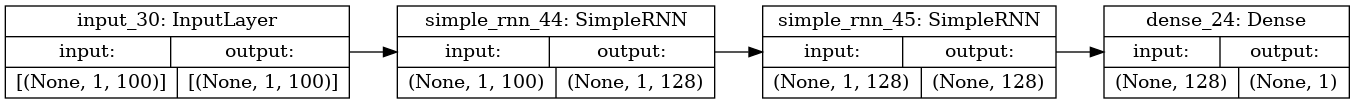

In [82]:
print(rnn.summary())
checkpoint_rnn = ModelCheckpoint('data/model_checkpoint/rnn.h5', save_best_only=True, verbose=1)
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(rnn, rankdir='LR', show_shapes=True)

In [83]:
rnn.fit(X_train.reshape(X_train.shape[0], -1, 100), label_train, epochs=100, batch_size=100,
        validation_data=(X_validation.reshape(X_validation.shape[0], -1, 100), label_validation), 
        callbacks=[checkpoint_rnn, reduce_lr])

Epoch 1/100
298/298 [==============================] - 4s 7ms/step - loss: 0.5749 - accuracy: 0.6893 - val_loss: 0.4749 - val_accuracy: 0.7811

Epoch 00001: val_loss improved from inf to 0.47488, saving model to data/model_checkpoint/rnn.h5
Epoch 2/100
298/298 [==============================] - 2s 6ms/step - loss: 0.4728 - accuracy: 0.7792 - val_loss: 0.4640 - val_accuracy: 0.7873

Epoch 00002: val_loss improved from 0.47488 to 0.46403, saving model to data/model_checkpoint/rnn.h5
Epoch 3/100
298/298 [==============================] - 2s 6ms/step - loss: 0.4672 - accuracy: 0.7830 - val_loss: 0.4626 - val_accuracy: 0.7849

Epoch 00003: val_loss improved from 0.46403 to 0.46263, saving model to data/model_checkpoint/rnn.h5
Epoch 4/100
298/298 [==============================] - 2s 5ms/step - loss: 0.4630 - accuracy: 0.7888 - val_loss: 0.4601 - val_accuracy: 0.7865

Epoch 00004: val_loss improved from 0.46263 to 0.46005, saving model to data/model_checkpoint/rnn.h5
Epoch 5/100
298/298 [===

# LSTM

In [98]:
lstm = Sequential()
lstm.add(Input(shape=(1, EMBEDDING_DIM)))
lstm.add(LSTM(256, return_sequences=True))
lstm.add(LSTM(128, return_sequences=True))
lstm.add(LSTM(8, return_sequences=False))
lstm.add(Dense(1, activation='sigmoid'))

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1, 256)            365568    
_________________________________________________________________
lstm_27 (LSTM)               (None, 1, 128)            197120    
_________________________________________________________________
lstm_28 (LSTM)               (None, 8)                 4384      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 567,081
Trainable params: 567,081
Non-trainable params: 0
_________________________________________________________________
None


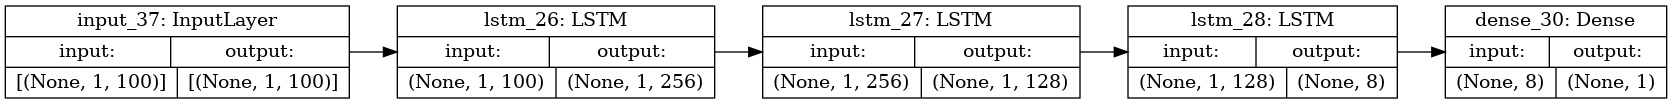

In [104]:
print(lstm.summary())
checkpoint_lstm = ModelCheckpoint('data/model_checkpoint/lstm.h5', save_best_only=True, verbose=1)
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(lstm, rankdir='LR', show_shapes=True)

In [102]:
lstm.fit(X_train.reshape(X_train.shape[0], -1, 100), label_train, epochs=100, batch_size=100,
        validation_data=(X_validation.reshape(X_validation.shape[0], -1, 100), label_validation), 
        callbacks=[checkpoint_lstm, reduce_lr])

Epoch 1/100
298/298 [==============================] - 12s 19ms/step - loss: 0.6203 - accuracy: 0.6324 - val_loss: 0.4807 - val_accuracy: 0.7750

Epoch 00001: val_loss improved from inf to 0.48069, saving model to data/model_checkpoint/lstm.h5
Epoch 2/100
298/298 [==============================] - 4s 14ms/step - loss: 0.4674 - accuracy: 0.7817 - val_loss: 0.4547 - val_accuracy: 0.7859

Epoch 00002: val_loss improved from 0.48069 to 0.45471, saving model to data/model_checkpoint/lstm.h5
Epoch 3/100
298/298 [==============================] - 4s 14ms/step - loss: 0.4577 - accuracy: 0.7836 - val_loss: 0.4641 - val_accuracy: 0.7825

Epoch 00003: val_loss did not improve from 0.45471
Epoch 4/100
298/298 [==============================] - 5s 17ms/step - loss: 0.4505 - accuracy: 0.7897 - val_loss: 0.4496 - val_accuracy: 0.7875

Epoch 00004: val_loss improved from 0.45471 to 0.44958, saving model to data/model_checkpoint/lstm.h5
Epoch 5/100
298/298 [==============================] - 4s 15ms/ste

# Bidirectional LSTM

In [151]:
bi_lstm = Sequential()
bi_lstm.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(1, EMBEDDING_DIM)))
bi_lstm.add(Bidirectional(LSTM(10)))
bi_lstm.add(Dense(1, activation='sigmoid'))

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 1, 20)             8880      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 21        
Total params: 11,381
Trainable params: 11,381
Non-trainable params: 0
_________________________________________________________________
None


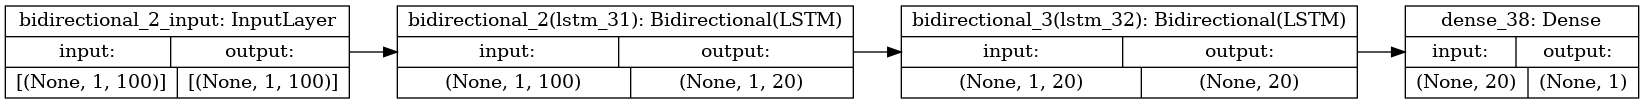

In [152]:
print(bi_lstm.summary())
checkpoint_bi_lstm = ModelCheckpoint('data/model_checkpoint/bi_lstm.h5', save_best_only=True, verbose=1)
bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(bi_lstm, rankdir='LR', show_shapes=True)

In [153]:
bi_lstm.fit(X_train.reshape(X_train.shape[0], -1, 100), label_train, epochs=100, batch_size=100,
        validation_data=(X_validation.reshape(X_validation.shape[0], -1, 100), label_validation), 
        callbacks=[checkpoint_bi_lstm, reduce_lr])

Epoch 1/100
298/298 [==============================] - 14s 16ms/step - loss: 0.6870 - accuracy: 0.5557 - val_loss: 0.6647 - val_accuracy: 0.6100

Epoch 00001: val_loss improved from inf to 0.66470, saving model to data/model_checkpoint/bi_lstm.h5
Epoch 2/100
298/298 [==============================] - 3s 8ms/step - loss: 0.5944 - accuracy: 0.7049 - val_loss: 0.5243 - val_accuracy: 0.7547

Epoch 00002: val_loss improved from 0.66470 to 0.52429, saving model to data/model_checkpoint/bi_lstm.h5
Epoch 3/100
298/298 [==============================] - 3s 8ms/step - loss: 0.5020 - accuracy: 0.7635 - val_loss: 0.4818 - val_accuracy: 0.7767

Epoch 00003: val_loss improved from 0.52429 to 0.48176, saving model to data/model_checkpoint/bi_lstm.h5
Epoch 4/100
298/298 [==============================] - 3s 8ms/step - loss: 0.4761 - accuracy: 0.7782 - val_loss: 0.4675 - val_accuracy: 0.7842

Epoch 00004: val_loss improved from 0.48176 to 0.46749, saving model to data/model_checkpoint/bi_lstm.h5
Epoch 

# CNN

In [120]:
'''Initializing the Convolutional Neural Network'''
cnn = Sequential()
cnn.add(Convolution1D(64, kernel_size=5, input_shape=(EMBEDDING_DIM, 1), activation='relu'))
cnn.add(MaxPool1D(pool_size=2))
cnn.add(Convolution1D(32, kernel_size=5, activation='relu'))
cnn.add(MaxPool1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 96, 64)            384       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 44, 32)            10272     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 704)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                22560     
_________________________________________________________________
dense_36 (Dense)             (None, 1)               

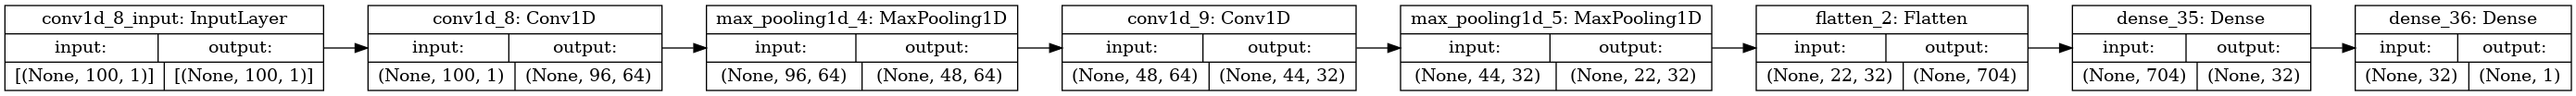

In [121]:
print(cnn.summary())
checkpoint_cnn = ModelCheckpoint('data/model_checkpoint/cnn.h5', save_best_only=True, verbose=1)
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(cnn, rankdir='LR', show_shapes=True)

In [122]:
cnn.fit(X_train.reshape(X_train.shape[0], 100, -1), label_train, epochs=100, batch_size=100,
        validation_data=(X_validation.reshape(X_validation.shape[0], 100, -1), label_validation), 
        callbacks=[checkpoint_cnn, reduce_lr]) 

Epoch 1/100
298/298 [==============================] - 5s 13ms/step - loss: 0.6731 - accuracy: 0.5788 - val_loss: 0.6103 - val_accuracy: 0.6631

Epoch 00001: val_loss improved from inf to 0.61027, saving model to data/model_checkpoint/cnn.h5
Epoch 2/100
298/298 [==============================] - 4s 12ms/step - loss: 0.5411 - accuracy: 0.7369 - val_loss: 0.5085 - val_accuracy: 0.7508

Epoch 00002: val_loss improved from 0.61027 to 0.50852, saving model to data/model_checkpoint/cnn.h5
Epoch 3/100
298/298 [==============================] - 4s 12ms/step - loss: 0.5017 - accuracy: 0.7566 - val_loss: 0.4864 - val_accuracy: 0.7720

Epoch 00003: val_loss improved from 0.50852 to 0.48643, saving model to data/model_checkpoint/cnn.h5
Epoch 4/100
298/298 [==============================] - 4s 13ms/step - loss: 0.4840 - accuracy: 0.7687 - val_loss: 0.4767 - val_accuracy: 0.7756

Epoch 00004: val_loss improved from 0.48643 to 0.47675, saving model to data/model_checkpoint/cnn.h5
Epoch 5/100
298/298 

# 7 - Đánh giá với 3 độ đo Accuracy, Confusion Matrix và F1-score và lưu kết quả ra 1 file

# 8 - Với mô hình học sâu có kết quả cao nhất ở trên, sử dụng điểm Checkpoint để lưu kết quả huấn luyện với epoch cho kết quả cao nhất

In [146]:
# load model with best saved checkpoint
mlp = load_model('data/model_checkpoint/mlp.h5')
rnn = load_model('data/model_checkpoint/rnn.h5')
lstm = load_model('data/model_checkpoint/lstm.h5')
bi_lstm = load_model('data/model_checkpoint/bi_lstm.h5')
cnn = load_model('data/model_checkpoint/cnn.h5')

In [127]:
def convert_pred(pred):
    out = []
    for p in pred.flatten():
        if p >= 0.5:
            out.append(1)
        else:
            out.append(0)
    return out 

In [139]:
def evaluate(model, X_test):
    pred = convert_pred(model.predict(X_test))
    print('Accuracy:', accuracy_score(label_test, pred))
    print('F1-scrore:', f1_score(label_test, pred))
    cm = confusion_matrix(label_test, pred, labels=list(index2class.keys()))
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=list(index2class.keys()))
    cm_disp.plot()
    plt.show()

MLP
Accuracy: 0.8035282258064517
F1-scrore: 0.8065124590489428


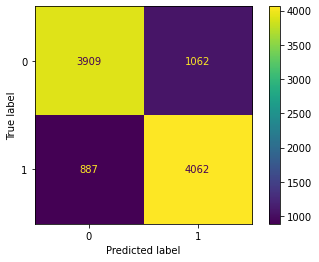

RNN
Accuracy: 0.7977822580645161
F1-scrore: 0.8024034672970842


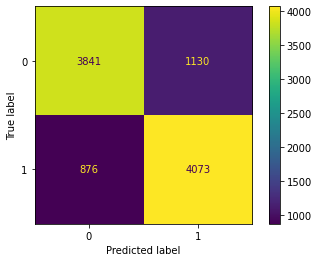

LSTM
Accuracy: 0.8025201612903226
F1-scrore: 0.8050552293760572


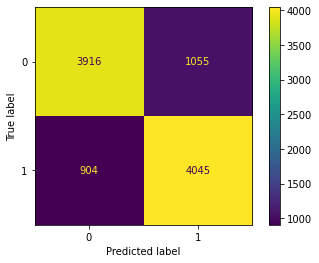

Bi-LSTM
Accuracy: 0.7991935483870968
F1-scrore: 0.8003607937462417


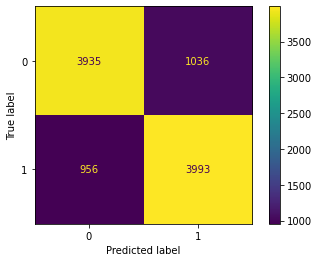

CNN
Accuracy: 0.8042338709677419
F1-scrore: 0.8080648349476182


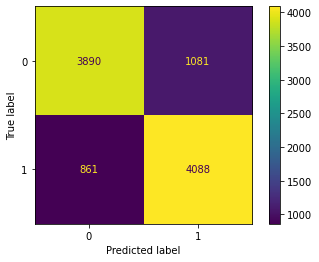

In [154]:
print('MLP')
evaluate(mlp, X_test)
print('RNN')
evaluate(rnn, X_test.reshape(X_test.shape[0], -1, 100))
print('LSTM')
evaluate(lstm, X_test.reshape(X_test.shape[0], -1, 100))
print('Bi-LSTM')
evaluate(bi_lstm, X_test.reshape(X_test.shape[0], -1, 100))
print('CNN')
evaluate(cnn, X_test.reshape(X_test.shape[0], 100, -1))

# 9 - Người dùng nhập vào một câu, sử dụng mô hình đã lưu ở trên dự đoán ý kiến của người dùng và in ra kết quả

In [ ]:
def predict_sentiment(sent):
    # missing preprocess
    embedded_sent = fasttext_pretrained_embed_sentence(sent)
    pred = convert_pred(mlp.predict(np.array([fasttext_pretrained_embed_sentence(sent)])).ravel())
    return index2class[pred[0]]

In [ ]:
predict_sentiment('quán này dở')

In [ ]:
predict_sentiment('thức_ăn ngon')